In [1]:
import cobra
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

## Chapter 14 problem 8

**Fermentation to Produce Soy Sauce**: Soy sauce is prepared by fermenting a salted mixture of soybeans and wheat with several microorganisms, including yeast, over a period of 8 to 12 months. The resulting sauce (after solids are removed) is rich in lactate and ethanol. How are these two compounds produced? To prevent the soy sauce from having a strong vinegar taste (vinegar is dilute acetic acid), oxygen must be kept out of the fermentation tank. Why?

Approach
1. Add fermentation reactions to glycolysis (from pyruvate)
2. Fermentation is an adaptive mechanism to increase ATP yield. Restrict to one fermentation product and optimize for ATP


In [7]:
import cobra
glycolysis = cobra.io.load_json_model('../resources/glycolysis_model.json')
ecoli = cobra.io.load_json_model('../resources/iML1515.json')

glycolysis.reactions.EX_glc__D_c.lower_bound = -1
glycolysis.reactions.EX_o2_c.lower_bound = -1000
#glycolysis.reactions.pyr_to_ATP.knock_out()

# add ethanol fermentation
glycolysis.add_reaction(ecoli.reactions.ALCD2x)

# add acetate fermentation
glycolysis.add_reaction(ecoli.reactions.PDH)
glycolysis.add_reaction(ecoli.reactions.PTAr)
glycolysis.add_reaction(ecoli.reactions.ACKr)

# add outlet for ethanol + acetate
for r_id, r in {'EX_ac_c': 'ac_c -> ', 'EX_etoh_c': 'etoh_c -> ', 'PYRDC': 'h_c + pyr_c -> acald_c + co2_c'}.items():
    r_obj = cobra.Reaction(r_id)
    glycolysis.add_reaction(r_obj)
    r_obj.build_reaction_from_string(r)

FileNotFoundError: [Errno 2] No such file or directory: '../resources/glycolysis_model.json'

## Chapter 14 problem 10
Suppose you discovered a mutant
yeast whose glycolytic pathway was shorter because of
the presence of a new enzyme catalyzing the reaction:

glyeraldehyde 3 phosphate + h20 + nad -> nadh + h + 2phosphoglycerate

Text(0.5,0,'Shortcut flux')

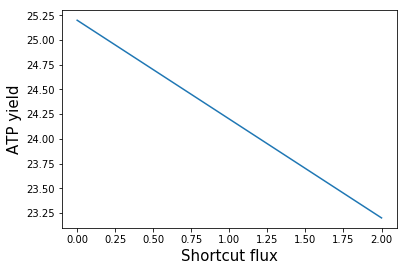

In [4]:
# Load Model
model = cobra.io.load_json_model('../resources/core_model.json')

# Add shortcut reaction
model.add_reaction(cobra.Reaction('shortcut'))
model.reactions.shortcut.build_reaction_from_string('g3p_c + h2o_c + nad_c -> nadh_c + h_c + 2pg_c')

# Assess ATP production ability
x = []
y = []
model.objective = 'shortcut'
for i in np.linspace(0, 2, 20): # Max flux through reaction is 2
    model.reactions.shortcut.lower_bound = i
    model.objective = 'ATPM'
    sol = model.optimize()
    x.append(i)
    y.append(sol.objective_value)
plt.plot(x, y)
plt.ylabel('ATP yield', size=15)
plt.xlabel('Shortcut flux', size=15)

### Trying problem 15, chapter 14

In [91]:
model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.EX_o2_c.lower_bound = 0
model.add_boundary(model.metabolites.akg_m)
model.reactions.EX_akg_m.lower_bound = 0
model.objective = 'ATPM'
model.reactions.ATPM.add_metabolites({'pi_c': .5}, combine=False)

sol = model.optimize()

In [92]:
sol.f

1.9999999999999991

In [93]:
for r in model.reactions.query('EX_'):
    print(r.id, r.flux)

EX_h_c 2.0000000000000004
EX_pyr_c 0.0
EX_h2o_c 7.200589331140302e-16
EX_pi_c -1.0000000000000002
EX_glc__D_c -1.0
EX_lac__L_c 1.9999999999999996
EX_co2_c -5.114956077737329e-16
EX_o2_c 0.0
EX_octa_c 0.0
EX_acetone_m 0.0
EX_bhb_m 0.0
EX_glygn2_c 0.0
EX_Tyr_ggn_c 0.0
EX_akg_m 0.0


In [84]:
model.reactions.EX_lac__L_c.flux

1.9999999999999996

In [85]:
model.reactions.EX_pi_c.flux

-1.0000000000000002

In [96]:
model.reactions.EX_pi_c.lower_bound = -.1
sol = model.optimize()

In [97]:
sol.f

0.19999999999999585

In [98]:
for r in model.reactions.query('EX_'):
    print(r.id, r.flux)

EX_h_c 1.9999999999999998
EX_pyr_c 0.0
EX_h2o_c 0.0
EX_pi_c -0.1
EX_glc__D_c -1.0
EX_lac__L_c 1.999999999999998
EX_co2_c -3.0873829569997055e-16
EX_o2_c 5.947623346206209e-18
EX_octa_c 0.0
EX_acetone_m 0.0
EX_bhb_m 0.0
EX_glygn2_c 1.5734754434704247e-18
EX_Tyr_ggn_c 0.0
EX_akg_m 0.0


### Problem 29, chapter 14

In [99]:
model = cobra.io.load_json_model('../models/core_model.json')

In [100]:
model.reactions.EX_lac__L_c.lower_bound = -1
model.objective = 'EX_glc__D_c'

In [101]:
model.optimize()

,fluxes,reduced_costs
CSm,0.194444,2.220446e-16
ACONTm,0.194444,0.000000e+00
ICDHxm,0.194444,1.443290e-15
AKGDm,0.194444,-1.554312e-15
SUCOAS1m,-0.194444,1.554312e-15
...,...,...
EX_octa_c,0.000000,-2.750000e+00
EX_acetone_m,0.000000,0.000000e+00
EX_bhb_m,0.000000,-1.194444e+00
EX_glygn2_c,0.000000,-2.200000e+01


In [102]:
model.reactions.EX_o2_c.flux

-0.583333333333337

In [103]:
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------
100%   0.806  ATPtm     adp_c + atp_m --> adp_m + atp_c

CONSUMING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%       FLUX  RXN ID    REACTION
----  ------  --------  ---------------------------------
100%   0.806  PGK       3pg_c + atp_c <=> 13dpg_c + adp_c


### Problem 29, chapter 14

In [126]:
model = cobra.io.load_json_model('../models/core_model.json')
model.objective = 'ATPM'
sol1 = model.optimize()
model.add_boundary(model.metabolites.oaa_c)
model.objective = 'EX_oaa_c'
model.reactions.PCm.knock_out()
sol2 = model.optimize()

In [127]:
sol1.f

25.19999999999994

In [128]:
sol2.f

0.0

In [119]:
df = (sol2.fluxes + 1) / (sol1.fluxes + 1)

In [167]:
model = cobra.io.load_json_model('../models/core_model.json')
model.add_boundary(model.metabolites.cit_m)
model.reactions.EX_cit_m.lower_bound = 0
model.reactions.NADM.knock_out()
sol = model.optimize()

df = pd.DataFrame()
x = []
y = []
for i in np.linspace(0, .5, 20):
    for r in ['ACONTm', 'NADH2_u10mi']:
        model.reactions.get_by_id(r).lower_bound = i * sol.fluxes[r]
        model.reactions.get_by_id(r).upper_bound = i * sol.fluxes[r]
        sol2 = model.optimize()
        print(sol2.f)
        df.loc[str(i), 'cit'] = sol2.fluxes['EX_cit_m']

9.2
2.0
2.036062378167643
2.61052631578947
2.484210526315792
3.221052631578941
3.0947368421052506
3.8315789473683877
3.705263157894726
4.442105263157842
4.315789473684192
5.052631578947308
4.926315789473658
5.663157894736759
5.536842105263107
6.273684210526182
6.14736842105267
6.8842105263157585
6.757894736841999
7.49473684210513
7.368421052631394
8.105263157894703
7.978947368421069
8.715789473684065
8.589473684210393
9.326315789473671
9.19999999999987
9.936842105263072
9.810526315789437
10.547368421052479
10.421052631578835
11.157894736841953
11.03157894736832
11.768421052631389
11.642105263157802
12.378947368420853
12.252631578947284
12.989473684210465
12.863157894736695
13.599999999999913


cobra/util/solver.py:408 UserWarning: solver status is 'infeasible'


In [332]:
df

,Exchange
EX_h_c,3.333333e-01
EX_pyr_c,1.657374e-14
EX_h2o_c,2.666667e+00
EX_pi_c,-4.817403e-15
EX_lac__L_c,-5.033011e-15
EX_co2_c,2.666667e+00
EX_o2_c,-5.000000e+00
EX_octa_c,-1.000000e+00
EX_bhb_m,1.333333e+00


In [130]:
a = cobra.flux_analysis.sample(model, 1000)

In [160]:
a.corr().loc['ACONTm', 'NADH2_u10mi']

0.7826047902300649

## Chapter 16 problem 23

In [170]:
model = cobra.io.load_json_model('../models/core_model.json')
model.add_reaction(cobra.Reaction("PC"))
model.reactions.PC.build_reaction_from_string('atp_c + hco3_c + pyr_c -> adp_c + h_c + oaa_c + pi_c')
model.add_boundary(model.metabolites.mal__L_c)
model.reactions.EX_glc__D_c.lower_bound =-1
model.reactions.EX_o2_c.lower_bound = 0
model.reactions.EX_co2_c.lower_bound = -100
model.objective = 'EX_mal__L_c'
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and r.x != 0:
        df.loc[r.id, 'Exchange'] = r.x
        print(r.id + ':', r.x)

EX_h_c: 4.0
EX_glc__D_c: -1.0
EX_co2_c: -2.0
EX_mal__L_c: 2.0


In [157]:
df

,Exchange
EX_h_c,4.0
EX_glc__D_c,-1.0
EX_co2_c,-2.0
EX_mal__L_c,2.0


In [193]:
# Chapter 17, problem 13 how much water from kilogram of fat

model = cobra.io.load_json_model('../models/core_model.json')
model.add_boundary(model.metabolites.coa_m)
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_glc__D_c.lower_bound = 0
model.reactions.EX_octa_c.lower_bound = -1
model.add_boundary(model.metabolites.accoa_m)
model.objective = 'EX_accoa_m'
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and r.x != 0:
        df.loc[r.id, 'Exchange'] = r.x
        print(r.id + ':', r.x)

In [220]:
# Chapter 17, problem 16 ketone bodies in diabetes

model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.EX_glc__D_c.lower_bound = 0
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_octa_c.upper_bound = -1
model.reactions.EX_o2_c.lower_bound = -5 # half of the full activity
sol = model.optimize()

df = pd.DataFrame()
for r in model.reactions:
    if 'EX_' in r.id and r.x != 0:
        df.loc[r.id, 'Exchange'] = r.x
        print(r.id + ':', r.x)
        
model.reactions.EX_bhb_m.knock_out()
model.reactions.EX_acetone_m.knock_out()
#model.add_boundary(model.metabolites.accoa_c)
#model.reactions.EX_accoa_c.upper_bound= 100
model.add_reaction(cobra.Reaction('accoa_to_coa'))
model.reactions.accoa_to_coa.build_reaction_from_string('accoa_m -> coa_m')

model.optimize()

EX_h_c: 0.3333333333334264
EX_pyr_c: 1.6573744473272203e-14
EX_h2o_c: 2.6666666666665657
EX_pi_c: -4.817402515547371e-15
EX_lac__L_c: -5.033011044967297e-15
EX_co2_c: 2.6666666666665746
EX_o2_c: -5.0
EX_octa_c: -1.0
EX_bhb_m: 1.3333333333334985


,fluxes,reduced_costs
CSm,1.0,-5.551115e-17
ACONTm,1.0,0.000000e+00
ICDHxm,1.0,0.000000e+00
AKGDm,1.0,0.000000e+00
SUCOAS1m,0.0,0.000000e+00
...,...,...
EX_acetone_m,0.0,3.122502e-17
EX_bhb_m,0.0,0.000000e+00
EX_glygn2_c,0.0,-5.000000e+01
EX_Tyr_ggn_c,0.0,0.000000e+00


In [216]:
find_sinks_sources(model, mets_to_skip=['octa_c', 'ac_c', 'occoa_c', 'occoa_m'])

cobra/util/solver.py:408 UserWarning: solver status is 'infeasible'


Before adding sinks:  <Solution infeasible at 0x1146cc9b0>
Maximize
1.0*ATPM - 1.0*ATPM_reverse_5b752
After adding sinks:  <Solution 1000.000 at 0x1147fd748>
250
Keeping 3hocoa_m_sink 0.1384083044981559 1.0
3ooctACP_c_source -1.161432061635992e-13
malACP_c_source 1.5158245029548803e-13
fad_m_sink -1.7763568394002505e-15
amp_c_source -2.220446049250313e-16
nadh_m_sink -8.881784197001252e-16


Name,None
Memory address,0x01148ebef0
Number of metabolites,129
Number of reactions,135
Objective expression,0
Compartments,"m, i, c, r,"


In [182]:
from fba4l.helper_functions.node_relaxing import find_sinks_sources
find_sinks_sources(model, mets_to_skip = ['glygn2_c', 'glygn1_c', 'ggn_c', 'udpg_c', 'dxtrn_c',
                                       '2pg_c', '3pg_c', 'e4p_c', 'mal__L_c', 'xu5p__D_c',
                                       'ru5p__D_c', 'dhap_c', 'g3p_c', 'r5p_c',
                                       'lac__L_c', 'glygn3_c', 's7p_c', 'g1p_c', 'g6p_c',
                                        'glc__D_c', 'glc__D_r', 'f6p_c', 'g6p_r', 'fdp_c',
                                        '6pgl_c', 'oaa_c', 'pep_m', 'pep_c', '13dpg_c',
                                        '6pgc_c', 'octa_c'])

Before adding sinks:  <Solution 0.000 at 0x1133a1240>
Maximize
1.0*EX_accoa_m - 1.0*EX_accoa_m_reverse_188b5
After adding sinks:  <Solution 1000.000 at 0x113a9ed68>
196


Name,None
Memory address,0x0113e42e80
Number of metabolites,129
Number of reactions,134
Objective expression,0
Compartments,"m, i, c, r,"


In [228]:
# Chapter 17, problem 17 consequences of a high fat diet

model = cobra.io.load_json_model('../models/core_model.json')
model.reactions.CSm.add_metabolites({'oaa_c': -.99}, # need to force activity of anaplerotic
                                    combine=False)
model.reactions.EX_co2_c.lower_bound = -100
model.reactions.EX_octa_c.lower_bound = -1
model.reactions.EX_octa_c.upper_bound = -1
model.reactions.EX_o2_c.lower_bound = -100

sol = model.optimize()
print(sol.fluxes['CSm'])
model.reactions.EX_glc__D_c.lower_bound = 0
sol = model.optimize()
print(sol.fluxes['CSm'])

2.0202020202020154
0.0


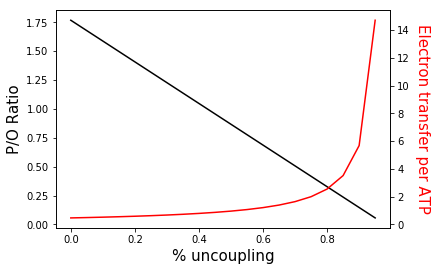

Text(0,0.5,'Glucose Uptake')

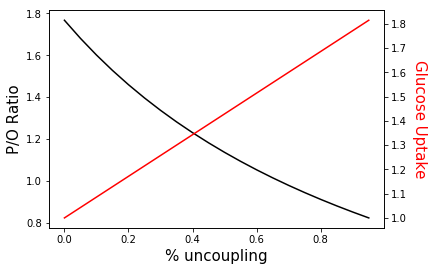

In [331]:
# Problem 6, chapter 19 uncouplers of ETC

model = cobra.io.load_json_model('../models/core_model.json')


x = []
y = []
y2=[]

# Find maximum uncoupling value possible
model.objective = 'Htmi'
sol = model.optimize()
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * sol.f
    model.objective = 'ATPM'
    model.optimize()
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append(model.reactions.NADH2_u10mi.flux / model.reactions.ATPS4mi.flux)
    x.append(i)
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')

ax2.set_ylabel('Electron transfer per ATP', fontdict={'color':'r',
                                                     'size': 15}, rotation=-90, labelpad=20)
plt.show()
plt.close()


model = cobra.io.load_json_model('../models/core_model.json')
sol_1 = model.optimize()

model.objective = 'Htmi'
x = []
y = []
y2=[]
sol = model.optimize()

model.reactions.ATPM.lower_bound = sol_1.x_dict['ATPM']
model.reactions.EX_glc__D_c.lower_bound = -10
for i in np.linspace(0, .95, 20):
    model.reactions.Htmi.lower_bound = i * sol.f
    
    model.objective = 'EX_glc__D_c'
    q = model.optimize()
    y.append(model.reactions.ATPS4mi.flux / abs((model.reactions.EX_o2_c.flux * 2)))
    y2.append(abs(model.reactions.EX_glc__D_c.flux))
    x.append(i)
plt.plot(x, y, 'k')
plt.ylabel('P/O Ratio', fontdict={'color':'k', 'size': 15})
plt.xlabel('% uncoupling', size=15)
ax2 = plt.twinx()
ax2.plot(x, y2, c='r')

ax2.set_ylabel('Glucose Uptake', fontdict={'color':'r',
                                                     'size': 15}, rotation=-90, labelpad=20)


In [328]:
model.reactions.ATPM.lower_bound

0.0

In [326]:
q.fluxes.ATPM

0.0